[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/masanorihirano/pams/blob/main/examples/market_share.ipynb)

In [1]:
# Please remove comment-out if necessary
#! pip install pams matplotlib

In [2]:
from pams import Market
from typing import Any
from typing import Dict
import numpy as np

## Only MarketShareFCNAgents

In [3]:
class ExtendedMarket(Market):
    def setup(self, settings: Dict[str, Any], *args, **kwargs) -> None:
        super(ExtendedMarket, self).setup(settings, *args, **kwargs)
        if "tradeVolume" in settings:
            if not isinstance(settings["tradeVolume"], int):
                raise ValueError("tradeVolume must be int")
            self._executed_volumes = [int(settings["tradeVolume"])]

In [4]:
from pams.logs import MarketStepEndLog
from pams.logs.market_step_loggers import MarketStepSaver

class MarketStepSaverForMarketShare(MarketStepSaver):
    def process_market_step_end_log(self, log: MarketStepEndLog) -> None:
        self.market_step_logs.append(
            {
                "session_id": log.session.session_id,
                "market_time": log.market.get_time(),
                "market_id": log.market.market_id,
                "market_name": log.market.name,
                "market_price": log.market.get_market_price(),
                "fundamental_price": log.market.get_fundamental_price(),
				"executed_volume": log.market.get_executed_volume(),
            }
        )

In [5]:
config1 = {
	"simulation": {
		"markets": ["Market-A", "Market-B"],
		"agents": ["MarketShareFCNAgents"],
		"sessions": [
			{	"sessionName": 0,
				"iterationSteps": 100,
				"withOrderPlacement": True,
				"withOrderExecution": False,
				"withPrint": True
			},
			{	"sessionName": 1,
				"iterationSteps": 2000,
				"withOrderPlacement": True,
				"withOrderExecution": True,
				"withPrint": True,
				"maxHighFrequencyOrders": 1
			}
		]
	},

	"Market-A": {
		"class": "ExtendedMarket",
		"tickSize": 10.0,
		"marketPrice": 300.0,
		"outstandingShares": 25000,

		"MEMO": "Required only here",
		"tradeVolume": 90
	},

	"Market-B": {
		"class": "ExtendedMarket",
		"tickSize": 1.0,
		"marketPrice": 300.0,
		"outstandingShares": 25000,

		"MEMO": "Required only here",
		"tradeVolume": 10
	},

	"MarketShareFCNAgents": {
		"class": "MarketShareFCNAgent",
		"numAgents": 100,

		"MEMO": "Agent class",
		"markets": ["Market-A", "Market-B"],
		"assetVolume": 50,
		"cashAmount": 10000,

		"MEMO": "FCNAgent class",
		"fundamentalWeight": {"expon": [1.0]},
		"chartWeight": {"expon": [0.2]},
		"noiseWeight": {"expon": [1.0]},
		"noiseScale": 0.0001,
		"timeWindowSize": [100, 200],
		"orderMargin": [0.0, 0.1],
		"marginType": "normal"
	}
}

In [6]:
import random
import matplotlib.pyplot as plt
from pams.runners import SequentialRunner

saver = MarketStepSaverForMarketShare()

runner = SequentialRunner(
    settings=config1,
    prng=random.Random(42),
    logger=saver,
)
runner.class_register(cls=ExtendedMarket)
runner.main()

E:\git\pams\pams\market.py:746: UserWarning: order price does not accord to the tick size. price will be modified
  warnings.warn(


# INITIALIZATION TIME 0.0049995
# EXECUTION TIME 0.5587208


In [7]:
market_prices_market_a = dict(sorted(map(lambda x: (x["market_time"], x["market_price"]), filter(lambda x: x["market_name"] == "Market-A", saver.market_step_logs))))
market_prices_market_b = dict(sorted(map(lambda x: (x["market_time"], x["market_price"]), filter(lambda x: x["market_name"] == "Market-B", saver.market_step_logs))))

fundamental_prices_market_a = dict(sorted(map(lambda x: (x["market_time"], x["fundamental_price"]), filter(lambda x: x["market_name"] == "Market-A", saver.market_step_logs))))
fundamental_prices_market_b = dict(sorted(map(lambda x: (x["market_time"], x["fundamental_price"]), filter(lambda x: x["market_name"] == "Market-B", saver.market_step_logs))))

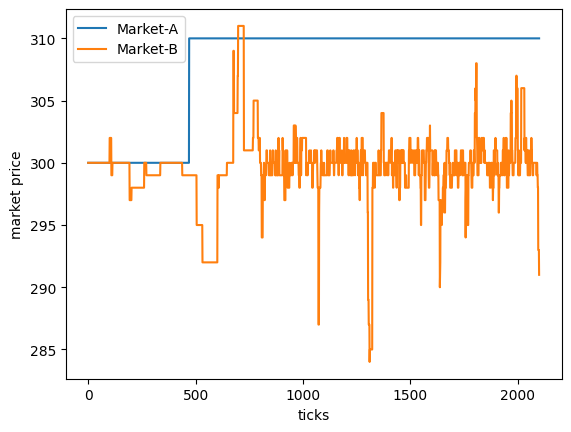

In [8]:
plt.plot(list(market_prices_market_a.keys()), list(market_prices_market_a.values()), label="Market-A")
plt.plot(list(market_prices_market_b.keys()), list(market_prices_market_b.values()), label="Market-B")
plt.xlabel("ticks")
plt.ylabel("market price")
plt.legend()
plt.show()

In [9]:
executed_volumes_market_a = np.convolve(np.ones(100), np.asarray(list(map(lambda x: x["executed_volume"], filter(lambda x: x["market_name"] == "Market-A", saver.market_step_logs)))[101:]), mode="valid")
executed_volumes_market_b = np.convolve(np.ones(100), np.asarray(list(map(lambda x: x["executed_volume"], filter(lambda x: x["market_name"] == "Market-B", saver.market_step_logs)))[101:]), mode="valid")
executed_volumes_total = executed_volumes_market_a + executed_volumes_market_b

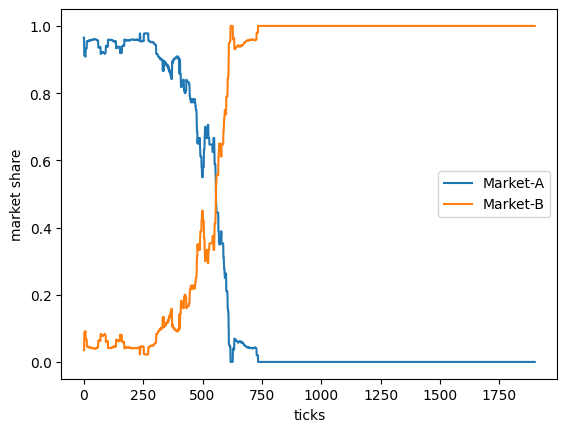

In [10]:
plt.plot(executed_volumes_market_a / executed_volumes_total, label="Market-A")
plt.plot(executed_volumes_market_b / executed_volumes_total, label="Market-B")
plt.xlabel("ticks")
plt.ylabel("market share")
plt.legend()
plt.show()

## MarketShareFCNAgents + MarketMakerAgent

In [11]:
config2 = {
	"simulation": {
		"markets": ["Market-A", "Market-B"],
		"agents": ["MarketShareFCNAgents", "MarketMakerAgent"],
		"sessions": [
			{	"sessionName": 0,
				"iterationSteps": 100,
				"withOrderPlacement": True,
				"withOrderExecution": False,
				"withPrint": True
			},
			{	"sessionName": 1,
				"iterationSteps": 2000,
				"withOrderPlacement": True,
				"withOrderExecution": True,
				"withPrint": True,
				"maxHighFrequencyOrders": 1
			}
		]
	},

	"Market-A": {
		"class": "ExtendedMarket",
		"tickSize": 0.00001,
		"marketPrice": 300.0,
		"outstandingShares": 25000,

		"MEMO": "Required only here",
		"tradeVolume": 90
	},

	"Market-B": {
		"class": "ExtendedMarket",
		"tickSize": 0.00001,
		"marketPrice": 300.0,
		"outstandingShares": 25000,

		"MEMO": "Required only here",
		"tradeVolume": 10
	},

	"MarketShareFCNAgents": {
		"class": "MarketShareFCNAgent",
		"numAgents": 100,

		"MEMO": "Agent class",
		"markets": ["Market-A", "Market-B"],
		"assetVolume": 50,
		"cashAmount": 10000,

		"MEMO": "FCNAgent class",
		"fundamentalWeight": {"expon": [1.0]},
		"chartWeight": {"expon": [0.0]},
		"noiseWeight": {"expon": [1.0]},
		"noiseScale": 0.001,
		"timeWindowSize": [100, 200],
		"orderMargin": [0.0, 0.1]
	},

	"MarketMakerAgent": {
		"class": "MarketMakerAgent",
		"numAgents": 1,

		"markets": ["Market-B"],
		"assetVolume": 50,
		"cashAmount": 10000,

		"targetMarket": "Market-B",
		"netInterestSpread": 0.02,
		"orderTimeLength": 2
	}
}

In [12]:
saver = MarketStepSaverForMarketShare()

runner = SequentialRunner(
    settings=config2,
    prng=random.Random(42),
    logger=saver,
)
runner.class_register(cls=ExtendedMarket)
runner.main()

# INITIALIZATION TIME 0.0039968
# EXECUTION TIME 0.8193277


In [13]:
market_prices_market_a = dict(sorted(map(lambda x: (x["market_time"], x["market_price"]), filter(lambda x: x["market_name"] == "Market-A", saver.market_step_logs))))
market_prices_market_b = dict(sorted(map(lambda x: (x["market_time"], x["market_price"]), filter(lambda x: x["market_name"] == "Market-B", saver.market_step_logs))))

fundamental_prices_market_a = dict(sorted(map(lambda x: (x["market_time"], x["fundamental_price"]), filter(lambda x: x["market_name"] == "Market-A", saver.market_step_logs))))
fundamental_prices_market_b = dict(sorted(map(lambda x: (x["market_time"], x["fundamental_price"]), filter(lambda x: x["market_name"] == "Market-B", saver.market_step_logs))))

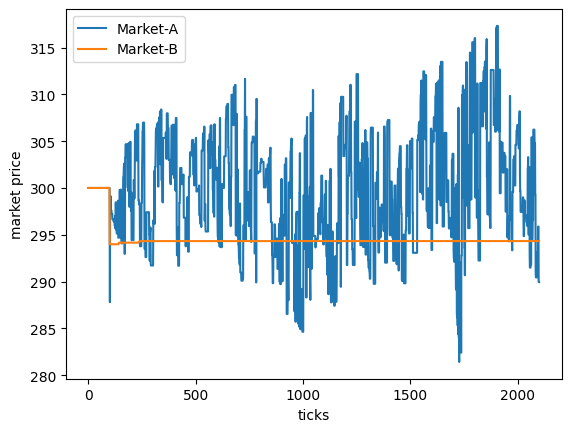

In [14]:
plt.plot(list(market_prices_market_a.keys()), list(market_prices_market_a.values()), label="Market-A")
plt.plot(list(market_prices_market_b.keys()), list(market_prices_market_b.values()), label="Market-B")
#plt.plot(list(fundamental_prices_market_a.keys()), list(fundamental_prices_market_a.values()), color='black')
#plt.plot(list(fundamental_prices_market_b.keys()), list(fundamental_prices_market_b.values()), color='black')
plt.xlabel("ticks")
plt.ylabel("market price")
plt.legend()
plt.show()

In [15]:
executed_volumes_market_a = np.convolve(np.ones(100), np.asarray(list(map(lambda x: x["executed_volume"], filter(lambda x: x["market_name"] == "Market-A", saver.market_step_logs)))), mode="valid")
executed_volumes_market_b = np.convolve(np.ones(100), np.asarray(list(map(lambda x: x["executed_volume"], filter(lambda x: x["market_name"] == "Market-B", saver.market_step_logs)))), mode="valid")
executed_volumes_total = executed_volumes_market_a + executed_volumes_market_b

D:\AppData\Local\Temp\ipykernel_15920\2371084761.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(executed_volumes_market_a / executed_volumes_total, label="Market-A")
D:\AppData\Local\Temp\ipykernel_15920\2371084761.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(executed_volumes_market_b / executed_volumes_total, label="Market-B")


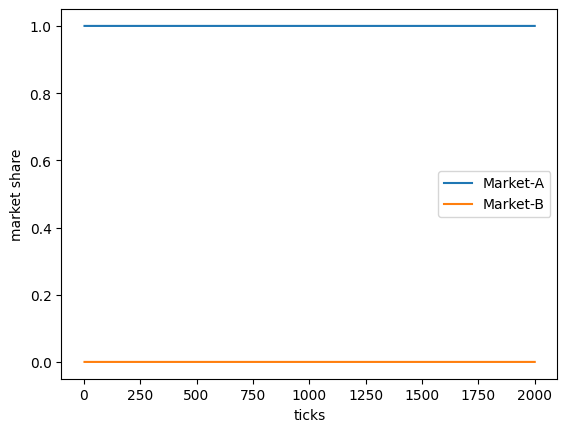

In [16]:
plt.plot(executed_volumes_market_a / executed_volumes_total, label="Market-A")
plt.plot(executed_volumes_market_b / executed_volumes_total, label="Market-B")
plt.xlabel("ticks")
plt.ylabel("market share")
plt.legend()
plt.show()